In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import os
from os import listdir
from os.path import isfile, join
import numpy as np
import pandas as pd
import cv2
import torchvision
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torch.optim as optim
import torch.nn.functional as F
from PIL import ImageFile
import matplotlib.pyplot as plt
import torch.nn.functional as f
from skimage import io
from torch.utils.data import (
    Dataset,
    DataLoader,
) 

In [ ]:
train_path='/content/drive/Shareddrives/Patter assignment/Dataset/Dataset A/training-a'

In [ ]:
Total_images = os.listdir(train_path)
print(Total_images)
df = pd.read_csv('/content/drive/Shareddrives/Patter assignment/Dataset/Dataset A/training-a.csv')
df.drop(['database name original','original filename' ,'scanid','contributing team','database name'], axis=1)


['a18741.png', 'a19021.png', 'a18701.png', 'a18804.png', 'a18821.png', 'a19170.png', 'a18867.png', 'a19215.png', 'a18749.png', 'a19114.png', 'a18780.png', 'a18687.png', 'a19025.png', 'a18927.png', 'a19052.png', 'a18895.png', 'a19118.png', 'a18725.png', 'a18747.png', 'a19209.png', 'a19131.png', 'a19056.png', 'a18806.png', 'a19008.png', 'a19249.png', 'a19185.png', 'a18723.png', 'a18695.png', 'a18810.png', 'a19221.png', 'a18940.png', 'a19032.png', 'a18923.png', 'a18854.png', 'a18938.png', 'a19117.png', 'a19083.png', 'a18826.png', 'a19146.png', 'a18758.png', 'a18740.png', 'a18846.png', 'a18992.png', 'a18790.png', 'a18967.png', 'a19003.png', 'a18911.png', 'a18947.png', 'a19140.png', 'a19120.png', 'a19081.png', 'a19193.png', 'a18726.png', 'a19094.png', 'a18776.png', 'a19078.png', 'a19096.png', 'a19235.png', 'a18916.png', 'a19232.png', 'a18795.png', 'a19097.png', 'a19188.png', 'a18965.png', 'a18692.png', 'a19174.png', 'a18729.png', 'a19238.png', 'a18982.png', 'a18928.png', 'a18732.png', 'a187

,filename,digit
0,a00000.png,5
1,a00001.png,3
2,a00002.png,1
3,a00003.png,7
4,a00004.png,0
...,...,...
19697,a19697.png,4
19698,a19698.png,3
19699,a19699.png,8
19700,a19700.png,3


In [ ]:
df['digit'].unique()

array([5, 3, 1, 7, 0, 4, 9, 8, 2, 6])

In [ ]:
df['digit'].value_counts()

2    1984
6    1983
4    1982
3    1976
0    1975
5    1965
9    1964
1    1963
7    1960
8    1950
Name: digit, dtype: int64

In [ ]:
IMAGE_SIZE = 38 
transform = transforms.Compose([
                                transforms.ToPILImage(),
                                # transforms.Grayscale(),
                                torchvision.transforms.ColorJitter(brightness=0.4,saturation=0.4,contrast=0.4,hue=0.4),
                                transforms.RandomRotation(20,expand=True), 
                                transforms.Resize(IMAGE_SIZE),  ## image resize
                                transforms.CenterCrop(IMAGE_SIZE), ## image center crop
                                transforms.ToTensor(), ## array converted into torch tensor and then divided by 255 (1.0/255)
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                
                               ])

**Data**

In [ ]:
class digit_Dataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=True):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = cv2.imread(img_path)
        y_label = torch.tensor(int(self.annotations.iloc[index, 3]))

        if self.transform:
            image = self.transform(image)

        return (image, y_label)

In [ ]:
dataset =digit_Dataset(
    csv_file="/content/drive/Shareddrives/Patter assignment/Dataset/Dataset A/training-a.csv",
    root_dir="/content/drive/Shareddrives/Patter assignment/Dataset/Dataset A/training-a",
    transform=transform,
)

In [ ]:
batch_size = 150
epoch =40
input_dim = 38*38 # num_features = 32400
num_hidden = 300 # num of hidden nodes
output_dim = 10

learning_rate = 0.01  

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
n = len(dataset) 
TEST_SIZE = 0.3
n_test = int(TEST_SIZE * n) # 10% validation
trainDataset, validDataSet = torch.utils.data.random_split(dataset,[n - n_test,n_test]) #random split dataset
trainloader = torch.utils.data.DataLoader(trainDataset, batch_size=batch_size, shuffle=True, pin_memory=True,) 
validationloader = torch.utils.data.DataLoader(validDataSet, batch_size=batch_size, shuffle=True, pin_memory=True,) 
print("Length of the trainloader:", len(trainloader ) * batch_size)
print("Length of the validationloader:", len(validationloader ) * batch_size)

Length of the trainloader: 13800
Length of the validationloader: 6000


In [ ]:
data_iter = iter(trainloader)
images, labels = data_iter.next()
images.shape

torch.Size([150, 3, 38, 38])

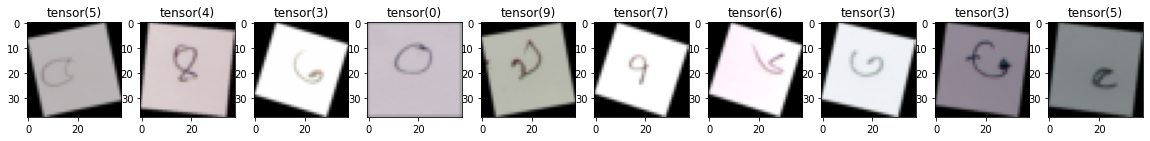

In [ ]:
dataiter = iter(trainloader)
images, labels = dataiter.next() 
plt.subplots(figsize=(20, 32))
for i in range(10):
    plt.subplot(10/2, 10,i+1)
    img = images[i].detach().numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5]) 
    std = np.array([0.5, 0.5, 0.5])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.title(labels[i])
    # print(img.shape)
    plt.imshow(img)
plt.show()

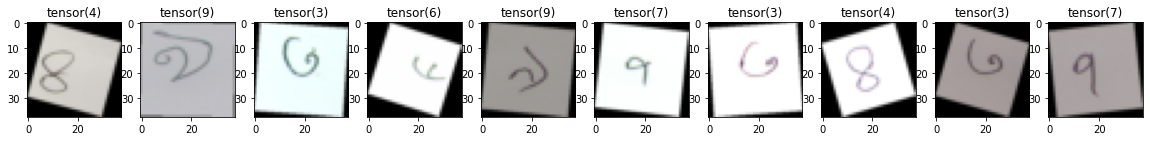

In [ ]:
dataiter = iter(validationloader)
images, labels = dataiter.next() 
plt.subplots(figsize=(20, 32))
for i in range(10):
    plt.subplot(10/2, 10,i+1)
    img = images[i].detach().numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5]) 
    std = np.array([0.5, 0.5, 0.5])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.title(labels[i])
    # print(img.shape)
    plt.imshow(img)
plt.show()

**Exp1**


 **Model 2.1**

In [ ]:
!pip install torchsummary
from torchsummary import summary

In [ ]:
class LIN_MODEL2_1(torch.nn.Module): 
    def __init__(self,outDim):
        super(LIN_MODEL2_1, self).__init__()

        self.fc_1 = torch.nn.Linear(3*38 * 38, 2000)
        self.fc_2 = torch.nn.Linear(2000, 1200)
        self.fc_3 = torch.nn.Linear(1200, 600)
        self.fc_4 = torch.nn.Linear(600, 180)
        self.fc_5 = torch.nn.Linear(180, 50)
        self.fc_6 = torch.nn.Linear(50, outDim)

        self.linear = torch.nn.Linear(3*38 * 38, outDim)
 
    def forward(self, x):

        x = x.view(-1, 3*38 * 38) 
        x = torch.nn.functional.relu(self.fc_1(x))
        x = torch.nn.functional.relu(self.fc_2(x))
        x = torch.nn.functional.relu(self.fc_3(x))
        x = torch.sigmoid(self.fc_4(x))
        x = torch.sigmoid(self.fc_5(x))
        x = self.fc_6(x)
        # x = torch.nn.functional.softmax(self.linear(x),dim=1)
        return x
        

model_2_1 = LIN_MODEL2_1(output_dim).to(device)
print(model_2_1)
# select CPU or GPU as a device



LIN_MODEL2_1(
  (fc_1): Linear(in_features=4332, out_features=2000, bias=True)
  (fc_2): Linear(in_features=2000, out_features=1200, bias=True)
  (fc_3): Linear(in_features=1200, out_features=600, bias=True)
  (fc_4): Linear(in_features=600, out_features=180, bias=True)
  (fc_5): Linear(in_features=180, out_features=50, bias=True)
  (fc_6): Linear(in_features=50, out_features=10, bias=True)
  (linear): Linear(in_features=4332, out_features=10, bias=True)
)


In [ ]:
model_2_1.cuda()

LIN_MODEL2_1(
  (fc_1): Linear(in_features=4332, out_features=2000, bias=True)
  (fc_2): Linear(in_features=2000, out_features=1200, bias=True)
  (fc_3): Linear(in_features=1200, out_features=600, bias=True)
  (fc_4): Linear(in_features=600, out_features=180, bias=True)
  (fc_5): Linear(in_features=180, out_features=50, bias=True)
  (fc_6): Linear(in_features=50, out_features=10, bias=True)
  (linear): Linear(in_features=4332, out_features=10, bias=True)
)

**Train**

In [ ]:
optimizer1 =  optim.SGD(model_2_1.parameters(), lr=0.07, momentum=0.9)
optimizer2 =  optim.Adam(model_2_1.parameters(), lr=0.07)
optimizer3 =  optim.RMSprop(model_2_1.parameters(), lr=0.07, momentum=0.9)
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
traininglosses = []
trainingaccuracy = []
testinglosses = []
testaccuracy = []
totalsteps = []
def train(trainDataset,batch_size,learning_rate,model,optimizer,epochs):
  Path='./model_2_1_final.pth'
  
  
  steps = 0
  running_loss = 0
  print_every = 3000

  #epoch iteration
  for epoch in range(epochs):
      accuracy = 0
      for inputs, labels in trainloader:
          model.train()
          steps += 1
          inputs, labels = inputs.to(device), labels.to(device)
          
          optimizer.zero_grad() 
          
          logps = model.forward(inputs.view(-1,3*38*38))
          loss = criterion(logps, labels)
          loss.backward() 
          optimizer.step() 
  
          #Calculate traning accuracy
          pred = torch.argmax(logps, dim=1)
          correct = pred.eq(labels)
        
          running_loss += loss.item()
          accuracy += torch.mean(correct.float())
          
          if steps % print_every == 0:
              after_train_accuracy=accuracy/print_every
              test_loss = 0
              accuracy = 0
              model.eval()
              with torch.no_grad():
                  for inputs, labels in validationloader:
                      inputs, labels = inputs.to(device), labels.to(device)
                      logps = model.forward(inputs.view(-1,3*38*38))
                      batch_loss = criterion(logps, labels)
                      
                      test_loss += batch_loss.item()
                      
                      pred = torch.argmax(logps, dim=1)
                      correct = pred.eq(labels)
                      accuracy += torch.mean(correct.float())
              
              traininglosses.append(running_loss/print_every)
              trainingaccuracy.append(after_train_accuracy)
              testinglosses.append(test_loss/len(validationloader))
              testaccuracy.append(accuracy/len(validationloader))
              totalsteps.append(steps)
              print(f"Device {device} "
                    f"Epoch {epoch+1}/{epochs} "
                    f"Step {steps} "
                    f"Train loss: {running_loss/print_every:f} "
                    f"Train accuracy: {after_train_accuracy:f} "
                    f"Test loss: {test_loss/len(validationloader):f} "
                    f"Test accuracy: {accuracy/len(validationloader):f}")
              running_loss = 0
              accuracy = 0
              model.train()
  print('Finish Train')
  torch.save(model.state_dict(), Path)

In [ ]:
train(trainDataset,batch_size,learning_rate,model_2_1,optimizer3,epoch)

Device cuda:0 Epoch 33/40 Step 3000 Train loss: 2.966808 Train accuracy: 0.001878 Test loss: 2.582348 Test accuracy: 0.091083
Finish Train


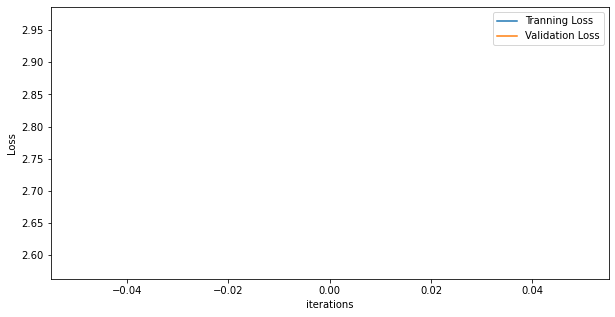

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(traininglosses,label="Tranning Loss")
plt.plot(testinglosses,label="Validation Loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

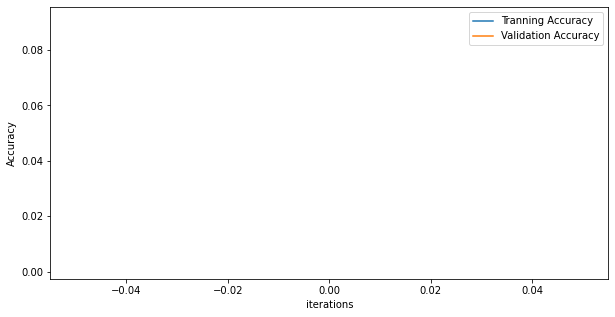

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(trainingaccuracy,label="Tranning Accuracy")
plt.plot(testaccuracy,label="Validation Accuracy")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
nb_classes = 10

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(validationloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model_2_1.forward(inputs.view(-1,3*38*38))
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

tensor([[  0., 542.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0., 577.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0., 615.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0., 604.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0., 580.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0., 590.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0., 581.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0., 612.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0., 612.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0., 597.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]])


Text(0.5, 15.0, 'Predicted label')

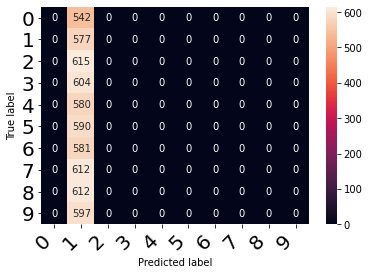

In [ ]:

import seaborn as sns
class_names = ["0","1","2","3","4","5","6","7","8","9"]
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=20)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=20)
plt.ylabel('True label')
plt.xlabel('Predicted label')